In [35]:
import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import tqdm
### notebook specific configuration ###
from os.path import basename
mpl.style.use('fivethirtyeight')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
rcParams['axes.grid'] = False

In [4]:
from Modules.Homer import *

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
sys.path.append('/home/isshamie/software/NGS-Pipeline')

In [6]:
ref_fa = '/data/genome/hamster/picr/picr.fa'
annotation = '/data/genome/hamster/picr/updated_final_sort.gff3'

mrna_peak = '/data/isshamie/TSS_CHO/mRNA.peak'

In [7]:
tissues = ['BloondnegSpleen','BMDM1hKLA1','BMDMwt','Brain','Brain7neg1',
          'FemaleReproductive','Heart','Intestine','Kidney','Liver','Lung',
           'MiscOrgans','Muscle','Pancreas','Skin','Spleen','Total','CHO']

In [6]:
len(tissues)

18

In [6]:
genome_ann_mrna = pd.read_csv(mrna_peak,sep='\t',index_col=0)

In [8]:
genome_ann_mrna.head()

,Chr,Start,End,Strand
ID,,,,
ID=asmbl_1;Parent=gene_1_1;gene_id=gene_1_1;gene=gene_1;transcript_id=asmbl_1;cs=5,picr_0,9,11,+
ID=asmbl_2;Parent=gene_1_2;gene_id=gene_1_2;gene=SERHL;transcript_id=asmbl_2;cs=2,picr_0,175,177,+
ID=asmbl_3;Parent=gene_1_3;gene_id=gene_1_3;gene=gene_1;transcript_id=asmbl_3;cs=5,picr_0,3879,3881,+
ID=asmbl_5;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_5;cs=2,picr_0,7714,7716,-
ID=asmbl_6;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_6;cs=1,picr_0,7714,7716,-


In [7]:
genome_ann_exon = pd.read_csv('/data/isshamie/TSS_CHO/exon.peak',sep='\t',index_col=0)

# For each gene ID, what is the distribution of number of exon peaks found across the gene body? 
Using genome annotation for exons, but our +/- 1kb for promoters (so we'll get some exons just by that virtue

#### Load in annotated peak and filter for exons

In [9]:
cho_mstart_anno = pd.read_csv('/data/isshamie/CH_tissue_TSS/CHO/mSTART/f06_annoPeaks/merge_bg_2.anno'
                              ,sep='\t',comment='#',index_col=0)
cho_mstart_anno.fillna('',inplace=True)
cho_mstart_exon = cho_mstart_anno[cho_mstart_anno['Annotation'].str.contains('exon ')]
cho_mstart_exon.head()

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type
PeakID (cmd=annotatePeaks.pl f04_peaks/merge_bg_2.peak /data/genome/hamster/picr/picr.fa -gff /data/genome/hamster/picr/updated_final_sort.gff3),,,,,,,,,,,,,,,,,,
Merged-picr_160-705648-2,picr_160,705573,705723,+,45987.101562,f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...,exon (ID=asmbl_25152.exon1;Parent=asmbl_25152;...,,103,ID=asmbl_25152.exon1;Parent=asmbl_25152;gene_i...,,,,,,,,
Merged-picr_8-16510895-2,picr_8,16510820,16510970,-,11816.900391,f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...,exon (ID=asmbl_77563.exon1;Parent=asmbl_77563;...,,115,ID=asmbl_77563.exon1;Parent=asmbl_77563;gene_i...,,,,,,,,
Merged-picr_157-1228462-2,picr_157,1228387,1228537,-,6019.100098,f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...,exon (ID=asmbl_23604.exon6;Parent=asmbl_23604;...,,-1052,ID=asmbl_23601.exon2;Parent=asmbl_23601;gene_i...,,,,,,,,
Merged-picr_19-9310549-2,picr_19,9310474,9310624,+,3773.699951,f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...,exon (ID=asmbl_28590.exon1;Parent=asmbl_28590;...,,377,ID=asmbl_28591.exon1;Parent=asmbl_28591;gene_i...,,,,,,,,
Merged-picr_35-11035053-2,picr_35,11034978,11035128,-,3525.899902,f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...,exon (ID=asmbl_47948.exon1;Parent=asmbl_47948;...,,-3966,ID=asmbl_47949.exon1;Parent=asmbl_47949;gene_i...,,,,,,,,


#### Load in geneCentric file example

In [10]:
gene_by_TSS = pd.read_csv('/data/isshamie/CH_tissue_TSS/CHO/mSTART/f06_annoPeaks/merge_bg_2.anno.geneCentric',index_col=0)
gene_by_TSS.dropna(axis=1,inplace=True) #Some unused columns
gene_by_TSS = gene_by_TSS[gene_by_TSS['hasPromoter']]

### Loop over tissues and types
#### Loop through each gene and add a column for number of exons found

In [87]:
def count_exons_by_TSS(f_gene_centric,f_peaks_annot,f_save=''):
    '''For each gene ID, what is the distribution of number of exon peaks found across the gene body?
    '''
    #### Load in geneCentric file
    curr_sample_anno = pd.read_csv(f_peaks_annot,sep='\t',comment='#',index_col=0)
    curr_sample_anno = curr_sample_anno.fillna('')
    curr_sample_exon = curr_sample_anno[curr_sample_anno['Annotation'].str.contains('exon ')]
    
    #### Loop through each gene and add a column for number of exons found
    gene_by_TSS = pd.read_csv(f_gene_centric,index_col=0)
    gene_by_TSS.dropna(axis=1,inplace=True) #Some unused columns
    gene_by_TSS = gene_by_TSS[gene_by_TSS['hasPromoter']]
    gene_by_TSS['Exon peaks'] = 0
    for ind,val in gene_by_TSS.iterrows():
        gene_by_TSS.set_value(ind,'Exon peaks',np.sum(curr_sample_exon['Annotation'].str.contains(ind)))

    #Save the gene_by_TSS
    gene_by_TSS.to_csv(f_gene_centric)

    #### Plot the distribution
    #Remove the top 99% exon peaks for some outliers 
    q = gene_by_TSS['Exon peaks'].quantile(0.99)
        
    #Plot the distribution of exons
    f = plt.figure()
    ax = f.add_subplot(111)
    sns.distplot(gene_by_TSS.loc[gene_by_TSS['Exon peaks']<q,'Exon peaks'],kde = False,axlabel='Number of exon peaks when gene has TSS');
    
    if not f_save == '':
        plt.savefig(f_save,bbox_inches='tight')
    plt.close()
    return gene_by_TSS

In [88]:
for curr_tissue in tissues: 
    i = '/data/isshamie/CH_tissue_TSS/' + curr_tissue    
    print curr_tissue
    curr_raw = glob.glob(i + '/*/')
    for j in curr_raw:
        curr_type = j.split('/')[-2]  
        print curr_type
        if not curr_type == 'ATAC':
            count = 1
            f_gene_centric  = j + 'f06_annoPeaks/merge_bg_2.anno.geneCentric'
            f_peaks_annot = j + 'f06_annoPeaks/merge_bg_2.anno'
            f_save = 'Results/Figures/exons_per_TSS/exon_per_TSS_%s_%s.png' % (curr_tissue,curr_type)
            if os.path.isfile(f_peaks_annot) and os.path.isfile(f_gene_centric):
                count_exons_by_TSS(f_gene_centric,f_peaks_annot,f_save)
            else:
                print 'Files not here for %s_%s' %(curr_tissue,curr_type) 
    

BloondnegSpleen
GRO
mSTART
Files not here for BloondnegSpleen_mSTART
ATAC
BMDM1hKLA1
GRO
ATAC
BMDMwt
GRO
ATAC
Brain
GRO
mSTART
ATAC
Brain7neg1
mSTART
Files not here for Brain7neg1_mSTART
FemaleReproductive
mSTART
Heart
mSTART
Intestine
mSTART
Files not here for Intestine_mSTART
Kidney
GRO
mSTART
ATAC
Liver
GRO
mSTART
ATAC
Lung
GRO
mSTART
ATAC
MiscOrgans
mSTART
Muscle
mSTART
Pancreas
mSTART
Skin
mSTART
Files not here for Skin_mSTART
Spleen
mSTART
Total
mSTART
Files not here for Total_mSTART
CHO
GRO
mSTART


In [150]:
def which_exon_peak_by_TSS(f_gene_centric,f_peaks_annot,f_save=''):
    '''For each gene ID, what is the distribution of number of exon peaks found across the gene body?
    '''
    #### Load in geneCentric file
    curr_sample_anno = pd.read_csv(f_peaks_annot,sep='\t',comment='#',index_col=0)
    curr_sample_anno = curr_sample_anno.fillna('')
    curr_sample_exon = curr_sample_anno[curr_sample_anno['Annotation'].str.contains('exon ')]
    
    #Find which exon number relative to the gene was it
    all_exon_nums = curr_sample_exon['Annotation'].apply(lambda x: re.search(r'exon(\d+);',x).group(1))
    all_exon_nums = all_exon_nums.astype(int)
    over_20 = np.sum(all_exon_nums > 20)
    plot_all_exon_nums = all_exon_nums[all_exon_nums < 20]
    plot_all_exon_nums = np.append(np.array(plot_all_exon_nums),20*np.ones([over_20,]))

    fig, ax = plt.subplots()
    sns.distplot(plot_all_exon_nums,kde=False,bins=20)#,axlabel='')
    ax.set_xlim([1,20])
    ax.set_xticks(range(1,20+1));

    fig.canvas.draw() #Fix plot 
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[-1] = '>20'

    ax.set_xticklabels(labels);
    ax.set_title('Which exon into the genes had peaks?')
    
    if not f_save == '':
        plt.savefig(f_save,bbox_inches='tight')
    plt.close()
    return plot_all_exon_nums

In [161]:
mstart_exons = []
gro_exons = []
for curr_tissue in tissues: 
    i = '/data/isshamie/CH_tissue_TSS/' + curr_tissue    
    print curr_tissue
    curr_raw = glob.glob(i + '/*/')
    for j in curr_raw:
        curr_type = j.split('/')[-2]  
        print curr_type
        if not curr_type == 'ATAC':
            count = 1
            f_gene_centric  = j + 'f06_annoPeaks/merge_bg_2.anno.geneCentric'
            f_peaks_annot = j + 'f06_annoPeaks/merge_bg_2.anno'
            f_save = 'Results/Figures/exons_positions/exon_positions_%s_%s.png' % (curr_tissue,curr_type)
            if os.path.isfile(f_peaks_annot) and os.path.isfile(f_gene_centric):
                if curr_type == 'mSTART':
                    mstart_exons.append(which_exon_peak_by_TSS(f_gene_centric,f_peaks_annot,f_save))
                else:
                    gro_exons.append(which_exon_peak_by_TSS(f_gene_centric,f_peaks_annot,f_save))
            else:
                print 'Files not here for %s_%s' %(curr_tissue,curr_type) 
    

BloondnegSpleen
GRO
mSTART
Files not here for BloondnegSpleen_mSTART
ATAC
BMDM1hKLA1
GRO
ATAC
BMDMwt
GRO
ATAC
Brain
GRO
mSTART
ATAC
Brain7neg1
mSTART
Files not here for Brain7neg1_mSTART
FemaleReproductive
mSTART
Heart
mSTART
Intestine
mSTART
Files not here for Intestine_mSTART
Kidney
GRO
mSTART
ATAC
Liver
GRO
mSTART
ATAC
Lung
GRO
mSTART
ATAC
MiscOrgans
mSTART
Muscle
mSTART
Pancreas
mSTART
Skin
mSTART
Files not here for Skin_mSTART
Spleen
mSTART
Total
mSTART
Files not here for Total_mSTART
CHO
GRO
mSTART


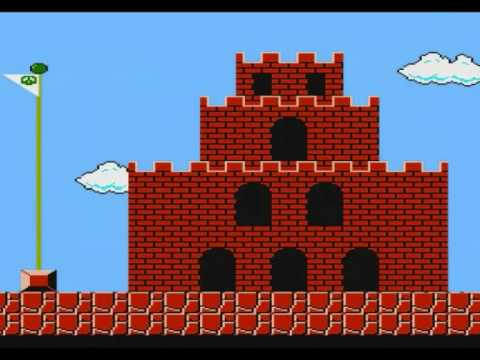

In [117]:
from IPython.display import Image
Image(filename='/home/isshamie/mario_chapter.jpg',width=600)

### Read in and plot based on Type and tissue

In [8]:
all_list = []
all_exons = pd.DataFrame()
for curr_tissue in tissues: 
    i = '/data/isshamie/CH_tissue_TSS/' + curr_tissue    
    print curr_tissue
    curr_raw = glob.glob(i + '/*/')
    for j in curr_raw:
        curr_type = j.split('/')[-2]  
        print curr_type
        if not curr_type == 'ATAC':
            count = 1
            f_gene_centric  = j + 'f06_annoPeaks/merge_bg_2.anno.geneCentric'
            f_peaks_annot = j + 'f06_annoPeaks/merge_bg_2.anno'
            f_save = 'Results/Figures/exons_per_TSS/exon_per_TSS_%s_%s.png' % (curr_tissue,curr_type)
            if os.path.isfile(f_peaks_annot) and os.path.isfile(f_gene_centric):
                all_list.append((curr_type,curr_tissue))
                curr = pd.read_csv(f_gene_centric,index_col=0)
                all_exons = all_exons.append(curr['Exon peaks'].transpose())
index = pd.MultiIndex.from_tuples(all_list, names=['type', 'tissue'])
all_exons.index = index


BloondnegSpleen
GRO
mSTART
ATAC
BMDM1hKLA1
GRO
ATAC
BMDMwt
GRO
ATAC
Brain
GRO
mSTART
ATAC
Brain7neg1
mSTART
FemaleReproductive
mSTART
Heart
mSTART
Intestine
mSTART
Kidney
GRO
mSTART
ATAC
Liver
GRO
mSTART
ATAC
Lung
GRO
mSTART
ATAC
MiscOrgans
mSTART
Muscle
mSTART
Pancreas
mSTART
Skin
mSTART
Spleen
mSTART
Total
mSTART
CHO
GRO
mSTART


GRO
mSTART


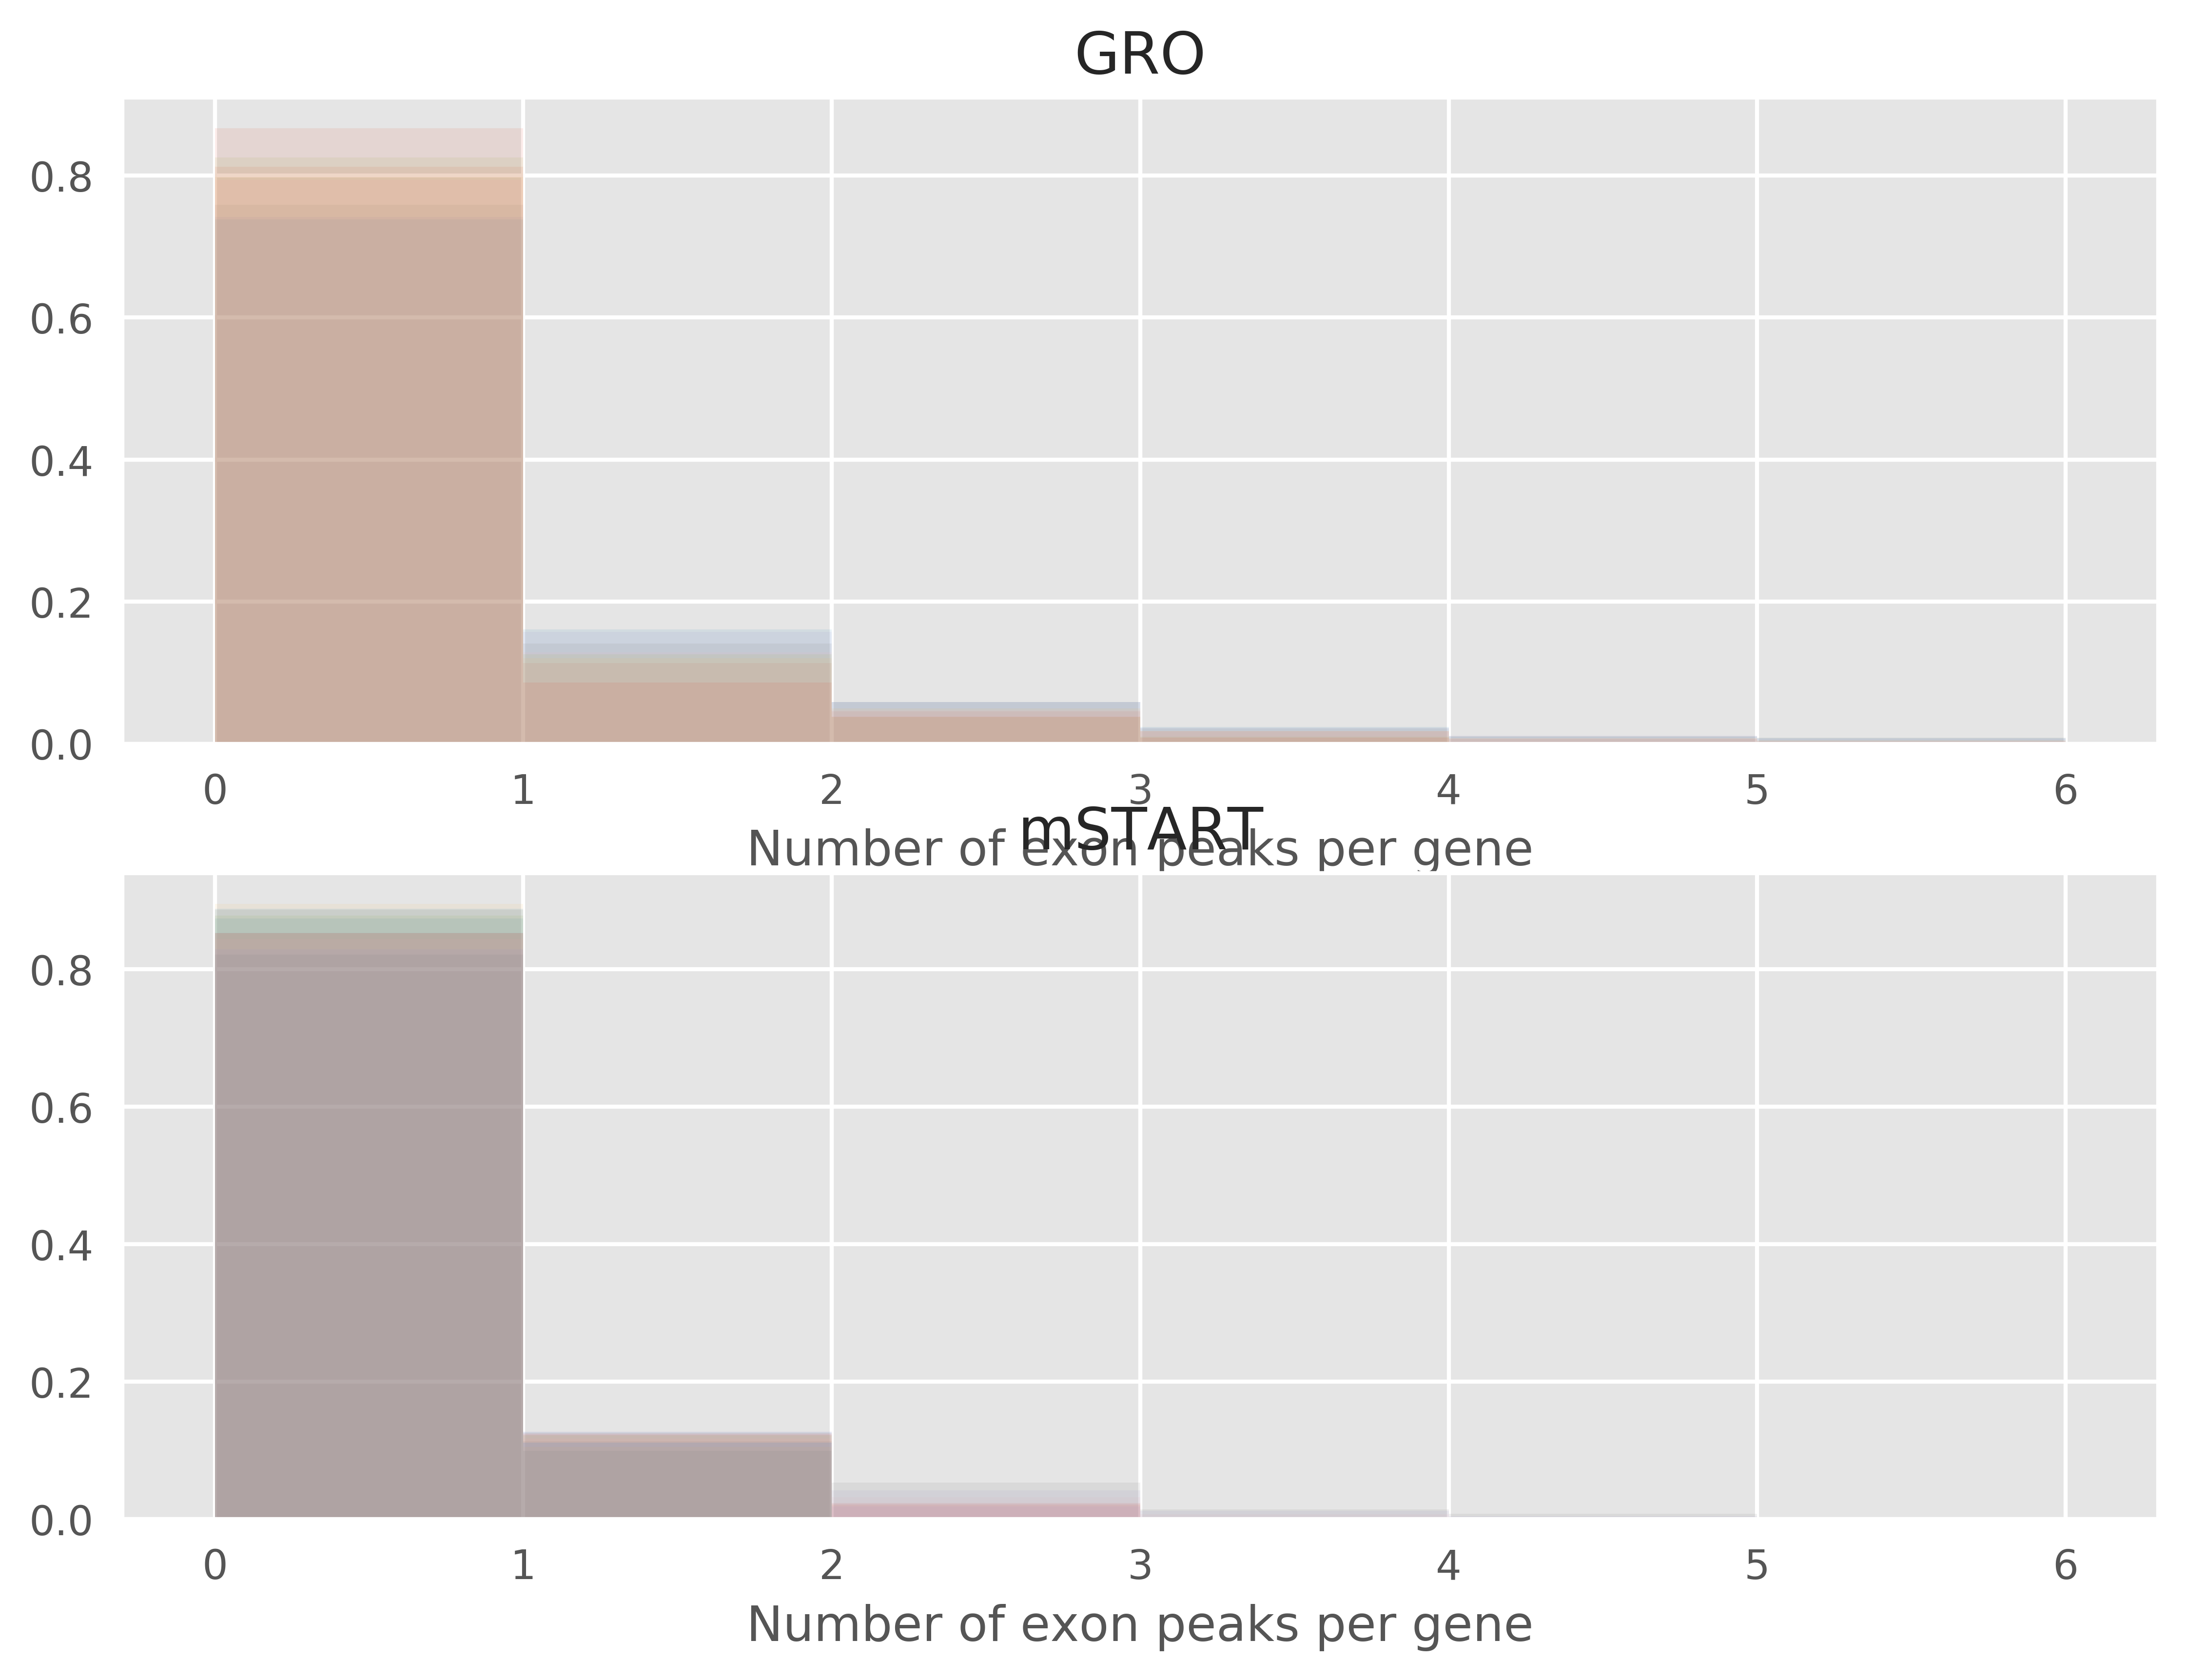

In [23]:
f = plt.figure(dpi=300)

num_types = len(set(all_exons.index.get_level_values('type')))

curr = 1
bins = np.linspace(0, 6, 7)

for ind,val in all_exons.groupby('type'):
    
    print ind
    ax = f.add_subplot(num_types,1,curr)
    for ind2,val2 in val.iterrows():
        q = np.percentile(val2.dropna(),99)
        tmp = val2.dropna()
        tmp = tmp[tmp<q]
        weights = np.ones_like(tmp)/float(len(tmp))
        
        ax.hist(tmp,weights=weights,bins=bins,alpha=0.1)
        
    ax.set_title(ind);
    ax.set_xlabel("Number of exon peaks per gene")
    curr += 1

plt.savefig('Results/Figures/exon_peak_numbers.png')
#f.close()
    

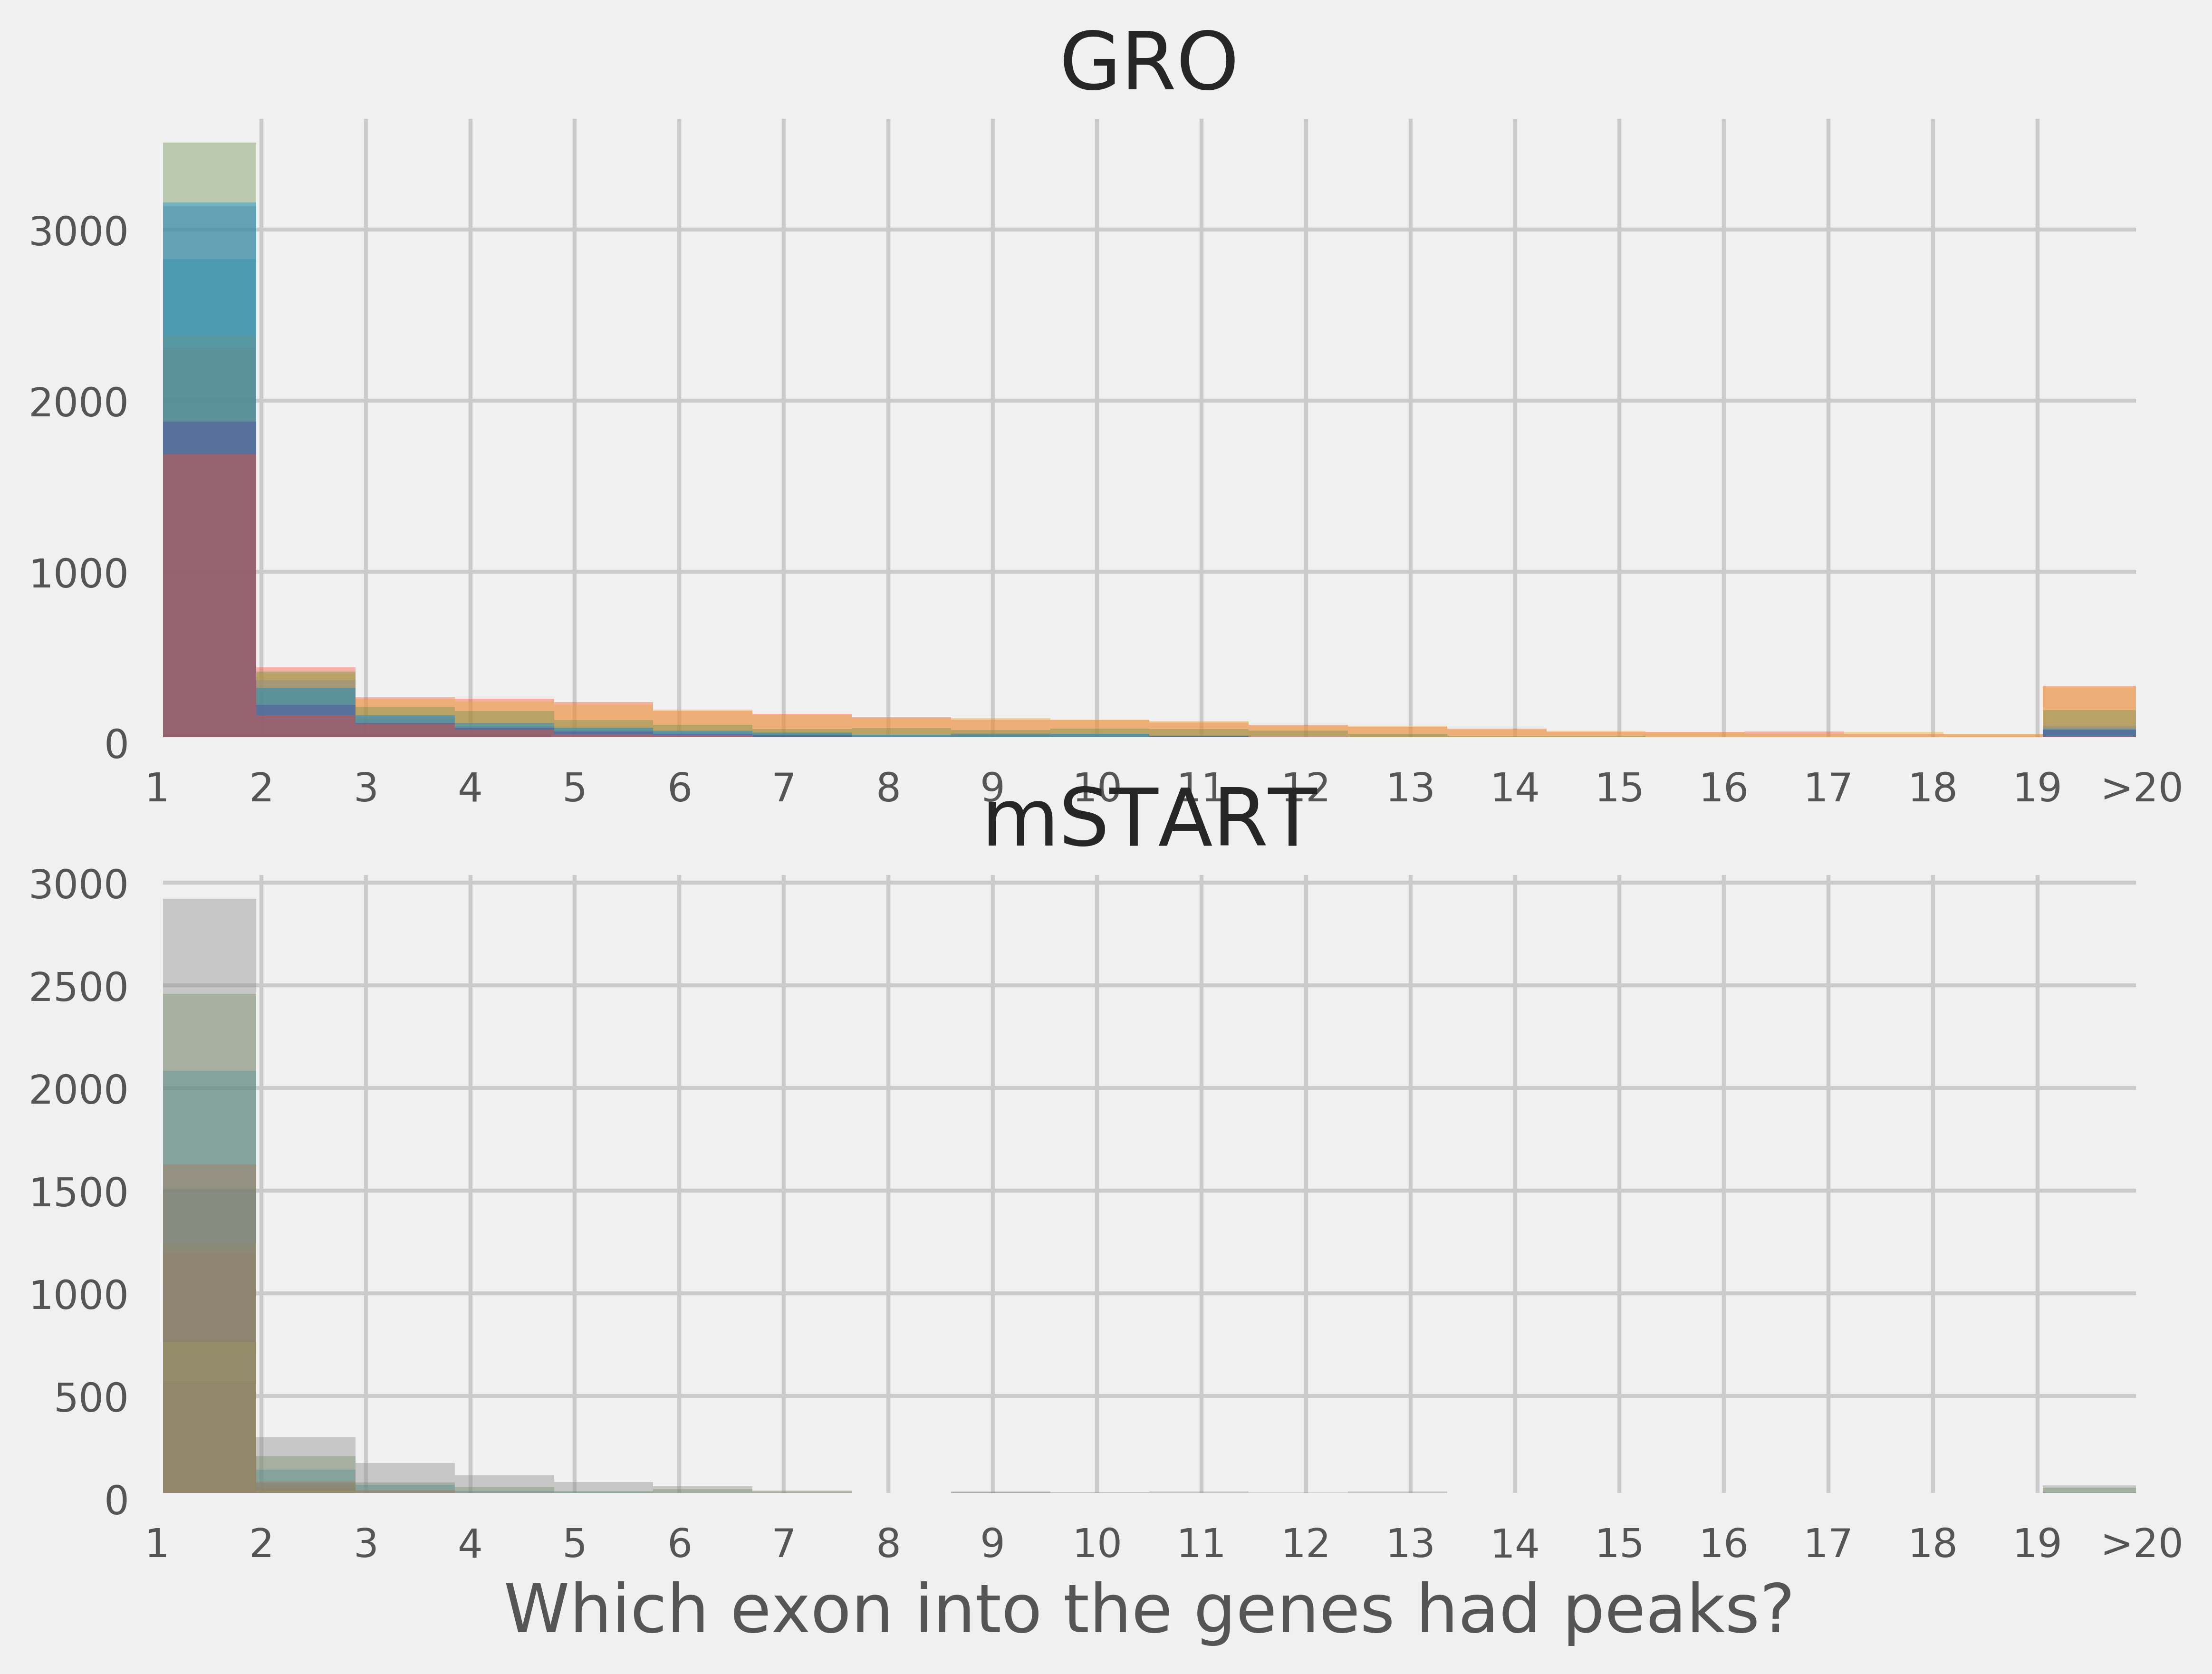

In [160]:
f = plt.figure(dpi=300)


#bins = np.linspace(0, 6, 7)    

ax = f.add_subplot(2,1,1)
for val in gro_exons:
    #ax.hist(val,weights=weights,bins=bins,alpha=0.1)
    #fig, ax = plt.subplots()
    sns.distplot(val,kde=False,bins=20)#,axlabel='')
    ax.set_xlim([1,20])
    ax.set_xticks(range(1,20+1));

    f.canvas.draw() #Fix plot 
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[-1] = '>20'
    ax.set_xticklabels(labels);
    ax.set_title('GRO')

ax = f.add_subplot(2,1,2)
for val in mstart_exons:
    
    sns.distplot(val,kde=False,bins=20)#,axlabel='')
    ax.set_xlim([1,20])
    ax.set_xticks(range(1,20+1));

    f.canvas.draw() #Fix plot 
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[-1] = '>20'

    ax.set_xticklabels(labels);
    ax.set_xlabel('Which exon into the genes had peaks?')    
    ax.set_title('mSTART')
plt.savefig('Results/Figures/exon_into_gene_numbers.png',bbox_inches='tight')

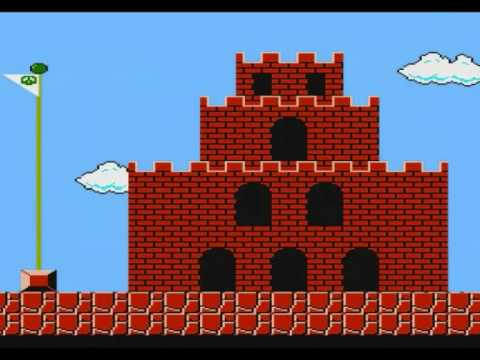

In [117]:
from IPython.display import Image
Image(filename='/home/isshamie/mario_chapter.jpg',width=600)

# For each gene ID, what is the correlation of promoter expression and gene body coverage? 
Using genome annotation for exons, but our +/- 1kb for promoters (so we'll get some exons just by that virtue

### Use Homer to annotatePeaks at tss and at rna, and then load them in and correlate the two

#### CHO

In [93]:
tag_file = 'CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001/' 
out_file = 'CHO/mSTART/f06_annoPeaks/trim_CHO--mSTART-JHS823_S21_R1_001_Coverage.txt'
cmd = 'annotatePeaks.pl tss %s -gff3 %s -size 500 -d %s > %s' % (ref_fa,annotation,tag_file,out_file)
print cmd

annotatePeaks.pl tss /data/genome/hamster/picr/picr.fa -gff3 /data/genome/hamster/picr/updated_final_sort.gff3 -size 500 -d CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001/ > CHO/mSTART/f06_annoPeaks/trim_CHO--mSTART-JHS823_S21_R1_001_Coverage.txt


In [24]:
tag_file = 'CHO/GRO/f03_tags/trim_CHO-5GRO-SD367_S6_R1_001/'
out_file = 'CHO/GRO/f06_annoPeaks/trim_CHO-5GRO-SD367_S6_R1_001_Coverage.txt'
cmd = 'annotatePeaks.pl tss %s -gff3 %s -size 500 -d %s > %s' % (ref_fa,annotation,tag_file,out_file)
print cmd

annotatePeaks.pl tss /data/genome/hamster/picr/picr.fa -gff3 /data/genome/hamster/picr/updated_final_sort.gff3 -size 500 -d CHO/GRO/f03_tags/trim_CHO-5GRO-SD367_S6_R1_001/ > CHO/GRO/f06_annoPeaks/trim_CHO-5GRO-SD367_S6_R1_001_Coverage.txt


In [95]:
cho_anno_tss = pd.read_csv('CHO/mSTART/f06_annoPeaks/trim_CHO--mSTART-JHS823_S21_R1_001_Coverage.txt',sep='\t',index_col=0)
cho_anno_tss

,Chr,Start,End,Strand,Not Used,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type,"CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001/ Tag Count in 500 bp (24217894.0 Total, normalization factor = 0.41, effective total = 10000000)"
PeakID (cmd=annotatePeaks.pl tss /data/genome/hamster/picr/picr.fa -gff3 /data/genome/hamster/picr/updated_final_sort.gff3 -size 500 -d CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001/),,,,,,,,,,,,,,,,,,,
gene_11595_1,picr_20,24707242,24707742,-,.,NaN,promoter-TSS (gene_11595_1),NaN,0,gene_11595_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
gene_18322,picr_4,25747204,25747704,-,.,NaN,promoter-TSS (gene_18322),NaN,0,gene_18322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.41
gene_5598,picr_13,18489712,18490212,-,.,NaN,promoter-TSS (gene_5598),NaN,0,gene_5598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.89
gene_28710,picr_85,7459335,7459835,-,.,NaN,promoter-TSS (gene_28710),NaN,0,gene_28710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.81
gene_7126_2,picr_145,1562548,1563048,+,.,NaN,promoter-TSS (gene_7126_2),NaN,0,gene_7126_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
gene_8752,picr_166,1101987,1102487,+,.,NaN,promoter-TSS (gene_8752),NaN,0,gene_8752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
gene_13367,picr_25,4738881,4739381,-,.,NaN,promoter-TSS (gene_13367),NaN,0,gene_13367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.41
gene_4693,picr_120,152267,152767,+,.,NaN,promoter-TSS (gene_4693),NaN,0,gene_4693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.65
gene_26067_2,picr_71,9697944,9698444,-,.,NaN,promoter-TSS (gene_26067_2),NaN,0,gene_26067_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00


In [102]:
out_file = 'CHO/mSTART/f06_annoPeaks/trim_CHO--mSTART-JHS823_S21_R1_001_Coverage_RNA.txt'
cmd = 'annotatePeaks.pl rna %s -gff3 %s -size 500 -d %s > %s' % (ref_fa,annotation,tag_file,out_file)
print cmd
sarge.run(cmd)

annotatePeaks.pl rna /data/genome/hamster/picr/picr.fa -gff3 /data/genome/hamster/picr/updated_final_sort.gff3 -size 500 -d CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001/ > CHO/mSTART/f06_annoPeaks/trim_CHO--mSTART-JHS823_S21_R1_001_Coverage_RNA.txt


In [105]:
cho_anno_rna = pd.read_csv('CHO/mSTART/f06_annoPeaks/trim_CHO--mSTART-JHS823_S21_R1_001_Coverage_RNA.txt',sep='\t')
cho_anno_rna

,PeakID (cmd=annotatePeaks.pl rna /data/genome/hamster/picr/picr.fa -gff3 /data/genome/hamster/picr/updated_final_sort.gff3 -size 500 -d CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001/),Chr,Start,End,Strand,Not Used,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type,"CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001/ Tag Count in 500 bp (24217894.0 Total, normalization factor = 0.41, effective total = 10000000)"
0,gene_26084,picr_71,10013072,10013572,-,"E9:9992623,I9:9995256,E8:9998825,I8:9998909,E7...",NaN,"intron (gene_26084, intron 2 of 8)",NaN,0,gene_26084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
1,gene_17107_2,picr_36,9917426,9917926,-,"E9:9910928,I9:9911062,E8:9912011,I8:9912101,E7...",NaN,"intron (gene_17107_2, intron 2 of 8)",NaN,0,gene_17107_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
2,gene_10068_2,picr_199,113622,114122,-,"E9:99021,I9:99231,E8:99021,I8:99231,E7:103439,...",NaN,"intron (gene_10068_1, intron 3 of 5)",NaN,0,gene_10068_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
3,gene_22781,picr_57,9899398,9899898,-,"E9:9894036,I9:9895149,E8:9894129,I8:9895149,E7...",NaN,"intron (gene_22781, intron 5 of 8)",NaN,0,gene_22781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
4,gene_27358,picr_8,9852204,9852704,-,"E9:9823830,I9:9826268,E8:9826958,I8:9827149,E7...",NaN,"intron (gene_27358, intron 1 of 8)",NaN,0,gene_27358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
5,gene_10284_1,picr_2,9829610,9830110,-,"E9:9815731,I9:9821474,E8:9821733,I8:9821824,E7...",NaN,"intron (gene_10284_2, intron 5 of 31)",NaN,0,gene_10284_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
6,gene_19820_3,picr_45,9804947,9805447,-,"E9:9769725,I9:9771557,E8:9776566,I8:9776721,E7...",NaN,"intron (gene_19820_3, intron 3 of 8)",NaN,0,gene_19820_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
7,gene_26621_3,picr_74,9771279,9771779,-,"E9:9767794,I9:9771217,E8:9771318,I8:9771459,E7...",NaN,"intron (gene_26621_3, intron 7 of 8)",NaN,0,gene_26621_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
8,gene_16851,picr_35,9752942,9753442,-,"E9:9747452,I9:9748585,E8:9749346,I8:9749487,E7...",NaN,"exon (gene_16851, exon 6 of 9)",NaN,0,gene_16851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.41
9,gene_8173,picr_16,9774973,9775473,-,"E9:9714738,I9:9716717,E8:9718050,I8:9718097,E7...",NaN,"intron (gene_8173, intron 1 of 8)",NaN,0,gene_8173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00


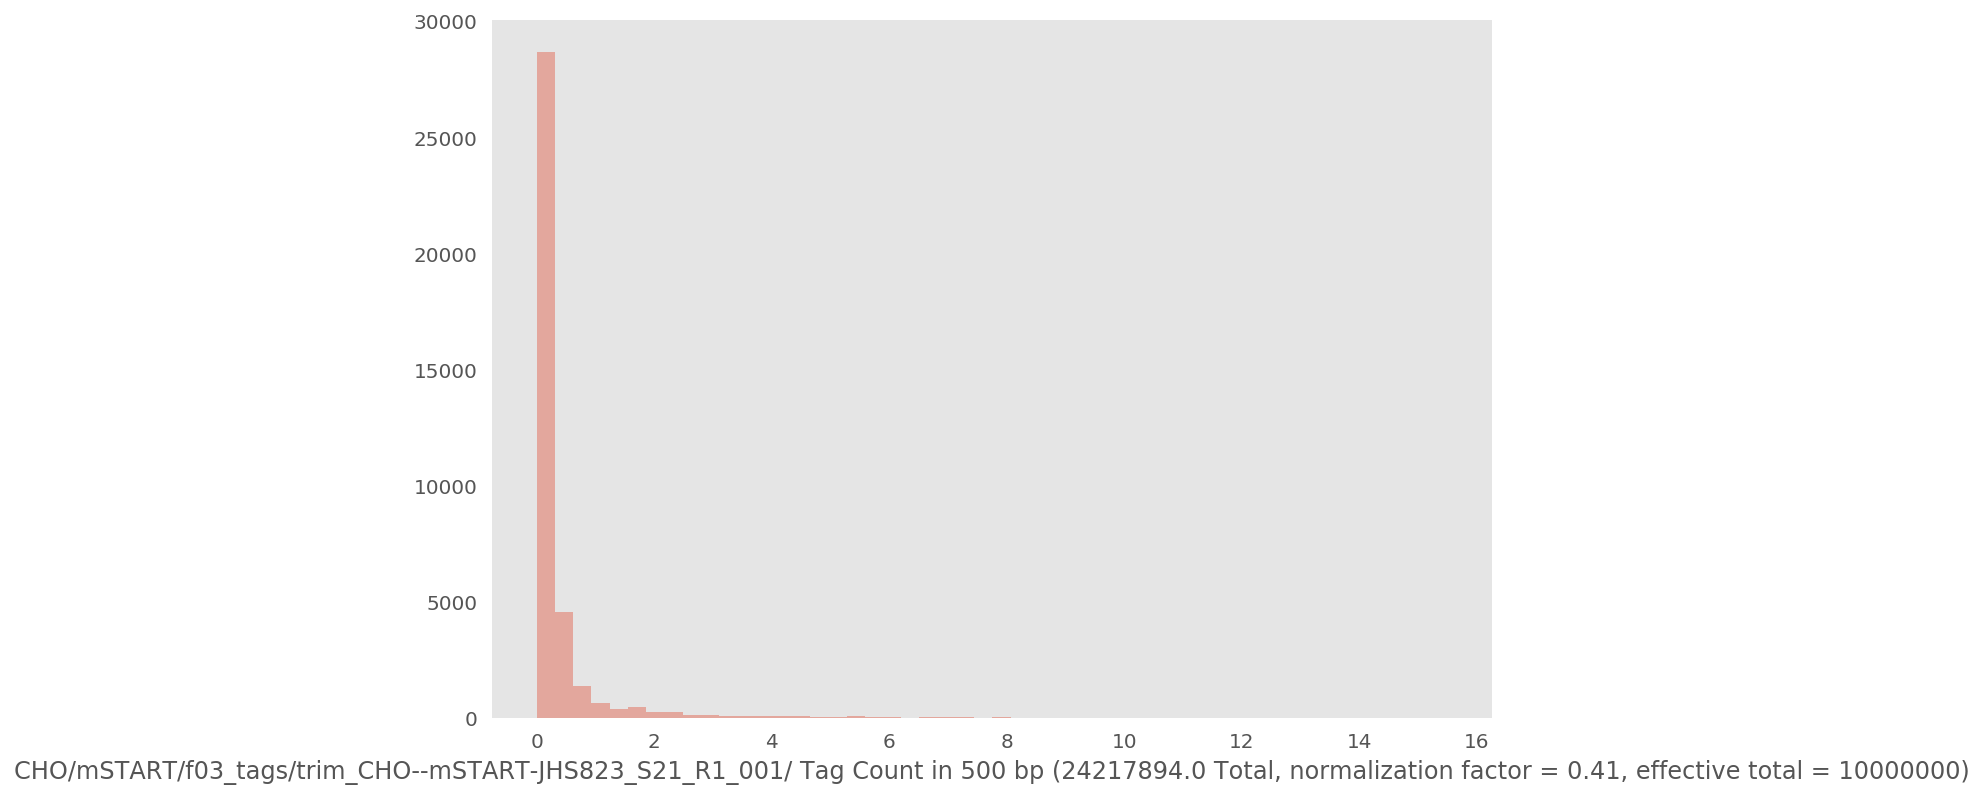

In [115]:
cho_anno_rna.fillna(0,inplace=True)
sns.distplot(np.log2(cho_anno_rna.iloc[:,-1]+1),kde=False)

In [111]:
print len(np.unique(cho_anno_rna.iloc[:,0]))
print cho_anno_rna.shape

38544
(38544, 20)


In [100]:
peak_file = 'CHO/mSTART/f04_peaks/merge_bg_2.peak'
out_file = 'CHO/mSTART/f06_annoPeaks/trim_CHO--mSTART-JHS823_S21_R1_001_METAGENE.txt'
cmd = 'makeMetaGeneProfile.pl %s %s -gff3 %s -size 500 -d %s -min 145 > %s' % (peak_file,ref_fa,annotation,tag_file,out_file)
print cmd
sarge.run(cmd)

makeMetaGeneProfile.pl CHO/mSTART/f04_peaks/merge_bg_2.peak /data/genome/hamster/picr/picr.fa -gff3 /data/genome/hamster/picr/updated_final_sort.gff3 -size 500 -d CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001/ -min 145 > CHO/mSTART/f06_annoPeaks/trim_CHO--mSTART-JHS823_S21_R1_001_METAGENE.txt


In [107]:
cho_metagene = pd.read_csv('CHO/mSTART/f06_annoPeaks/trim_CHO--mSTART-JHS823_S21_R1_001_METAGENE.txt',sep='\t')
cho_metagene

,Distance from Center (cmd=annotatePeaks.pl 0.308815488432632.2.tmp /data/genome/hamster/picr/picr.fa -size 1000 -hist 100 -gff3 /data/genome/hamster/picr/updated_final_sort.gff3 -d CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001/),CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001/ Coverage,CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001/ + Tags,CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001/ - Tags
0,-500,25.257333,0.018699,0.053908
1,-400,27.379189,0.023228,0.166889
2,-300,24.042317,0.026219,0.108027
3,-200,21.956000,0.016312,0.179734
4,-100,18.734532,0.013162,0.409138
5,0,11.367962,0.075752,0.184197
6,20,22.628665,0.037592,0.173467
7,40,21.038772,0.041188,0.139606
8,60,19.935009,0.047773,0.118796
9,80,19.168331,0.055009,0.112384


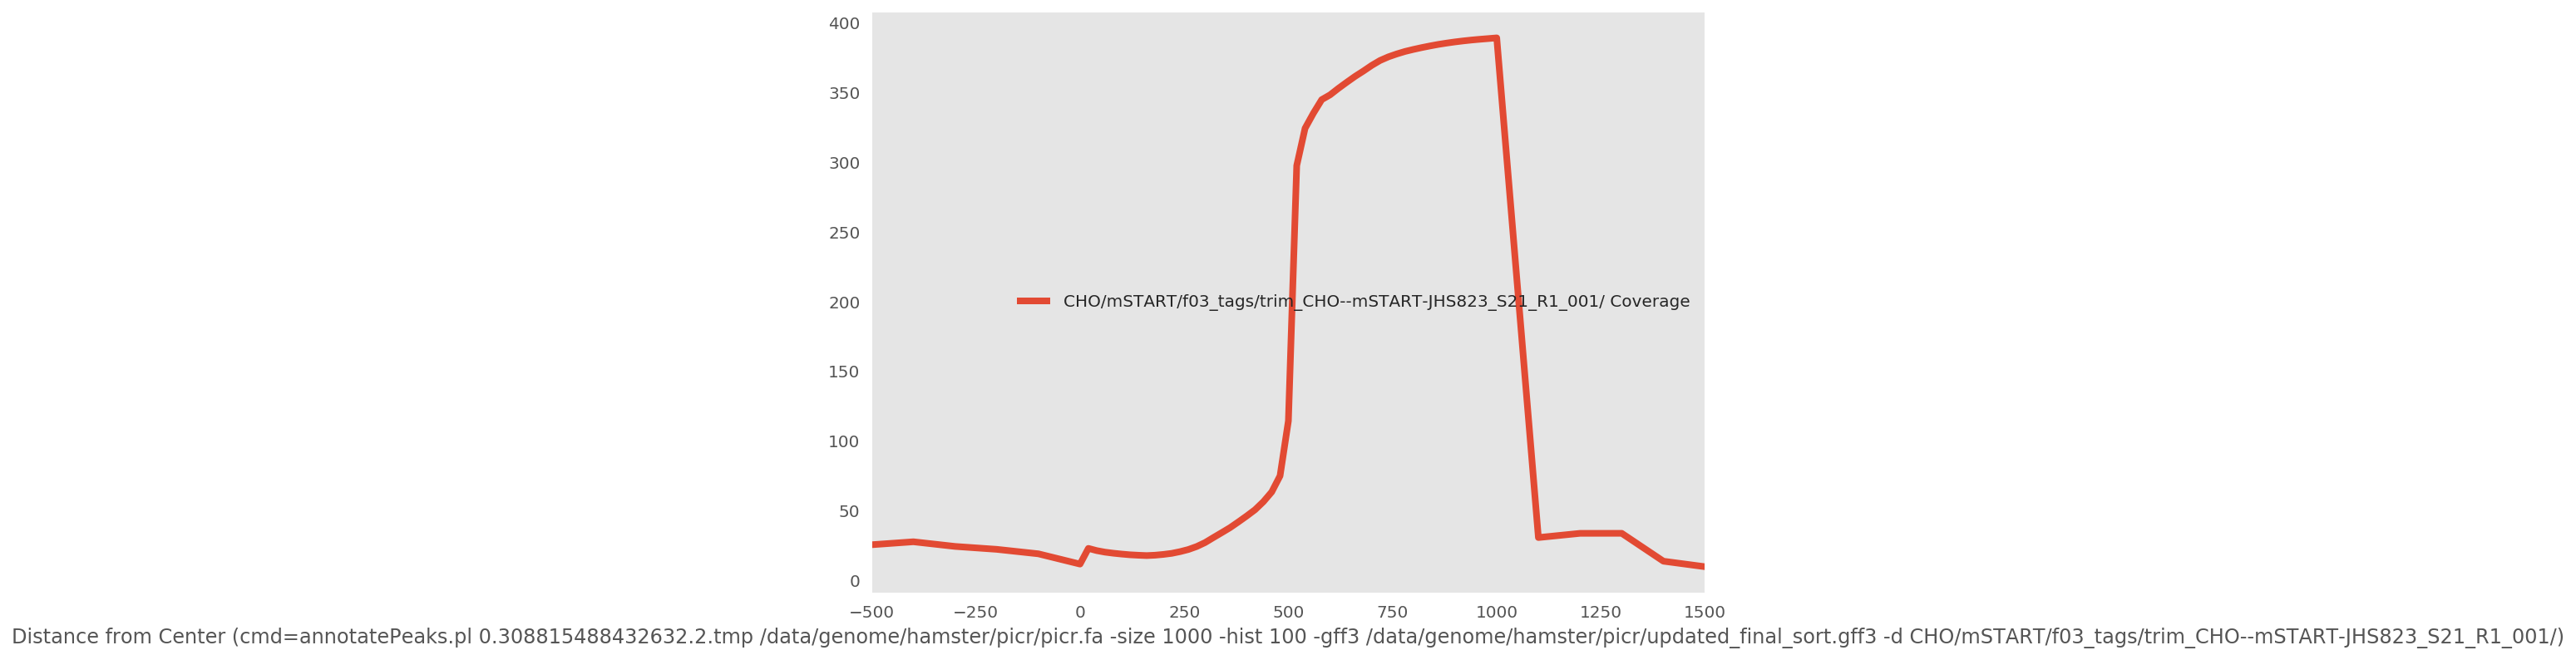

In [108]:
cho_metagene.plot('Distance from Center (cmd=annotatePeaks.pl 0.308815488432632.2.tmp /data/genome/hamster/picr/picr.fa -size 1000 -hist 100 -gff3 /data/genome/hamster/picr/updated_final_sort.gff3 -d CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001/)','CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001/ Coverage')

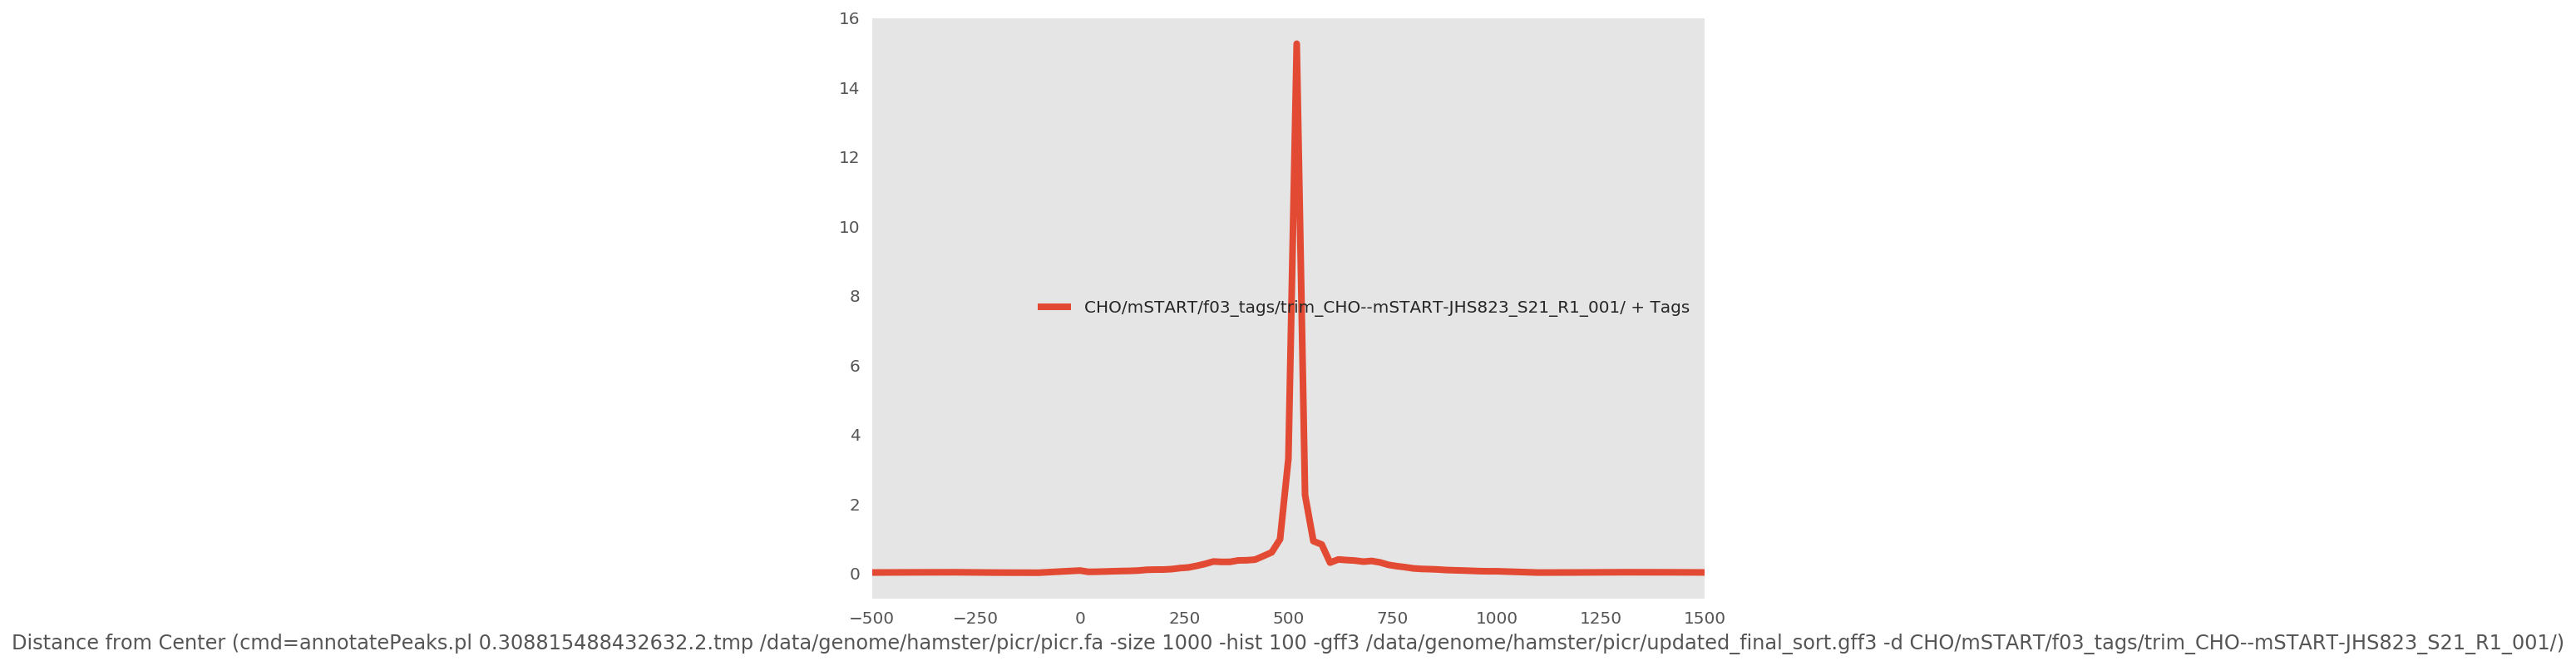

In [109]:
cho_metagene.plot('Distance from Center (cmd=annotatePeaks.pl 0.308815488432632.2.tmp /data/genome/hamster/picr/picr.fa -size 1000 -hist 100 -gff3 /data/genome/hamster/picr/updated_final_sort.gff3 -d CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001/)','CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001/ + Tags')

## CHO GRO

In [ ]:
ls CHO/GRO/f06_annoPeaks/

In [27]:
peak_file = 'CHO/GRO/f04_peaks/merge_bg_2.peak'
out_file = 'CHO/GRO/f06_annoPeaks/trim_CHO-5GRO-SD367_S6_R1_001_METAGENE.txt'
cmd = 'makeMetaGeneProfile.pl %s %s -gff3 %s -size 500 -d %s -min 145 > %s' % (peak_file,ref_fa,annotation,tag_file,out_file)
print cmd
sarge.run(cmd)



makeMetaGeneProfile.pl CHO/GRO/f04_peaks/merge_bg_2.peak /data/genome/hamster/picr/picr.fa -gff3 /data/genome/hamster/picr/updated_final_sort.gff3 -size 500 -d CHO/GRO/f03_tags/trim_CHO-5GRO-SD367_S6_R1_001/ -min 145 > CHO/GRO/f06_annoPeaks/trim_CHO-5GRO-SD367_S6_R1_001_METAGENE.txt


KeyError: 'Distance from Center (cmd=annotatePeaks.pl 0.308815488432632.2.tmp /data/genome/hamster/picr/picr.fa -size 1000 -hist 100 -gff3 /data/genome/hamster/picr/updated_final_sort.gff3 -d CHO/GRO/f03_tags/trim_CHO--GRO-JHS823_S21_R1_001/)'

In [30]:
cho_metagene.head()

,Distance from Center (cmd=annotatePeaks.pl 0.741687460643337.2.tmp /data/genome/hamster/picr/picr.fa -size 1000 -hist 100 -gff3 /data/genome/hamster/picr/updated_final_sort.gff3 -d CHO/GRO/f03_tags/trim_CHO-5GRO-SD367_S6_R1_001/),CHO/GRO/f03_tags/trim_CHO-5GRO-SD367_S6_R1_001/ Coverage,CHO/GRO/f03_tags/trim_CHO-5GRO-SD367_S6_R1_001/ + Tags,CHO/GRO/f03_tags/trim_CHO-5GRO-SD367_S6_R1_001/ - Tags
0,-500,16.897029,0.032455,0.057180
1,-400,23.967266,0.040716,0.075939
2,-300,40.633847,0.042019,0.109774
3,-200,43.561216,0.030923,0.175620
4,-100,35.952460,0.021584,0.373835


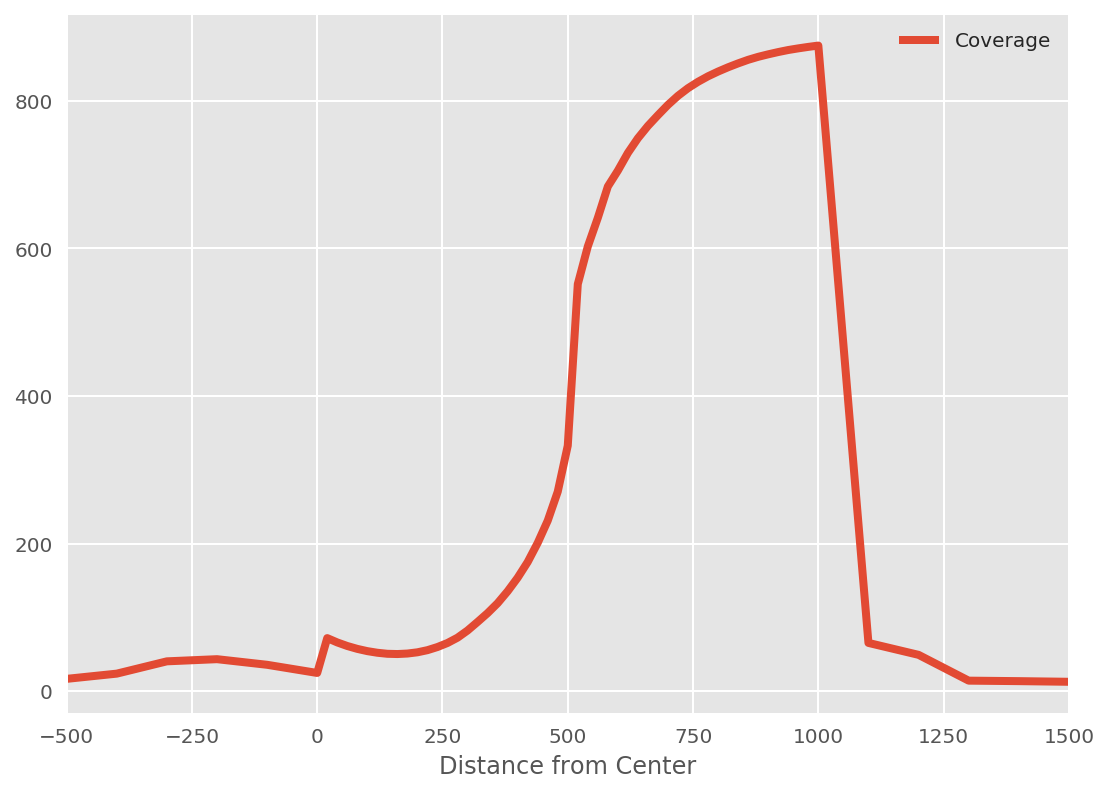

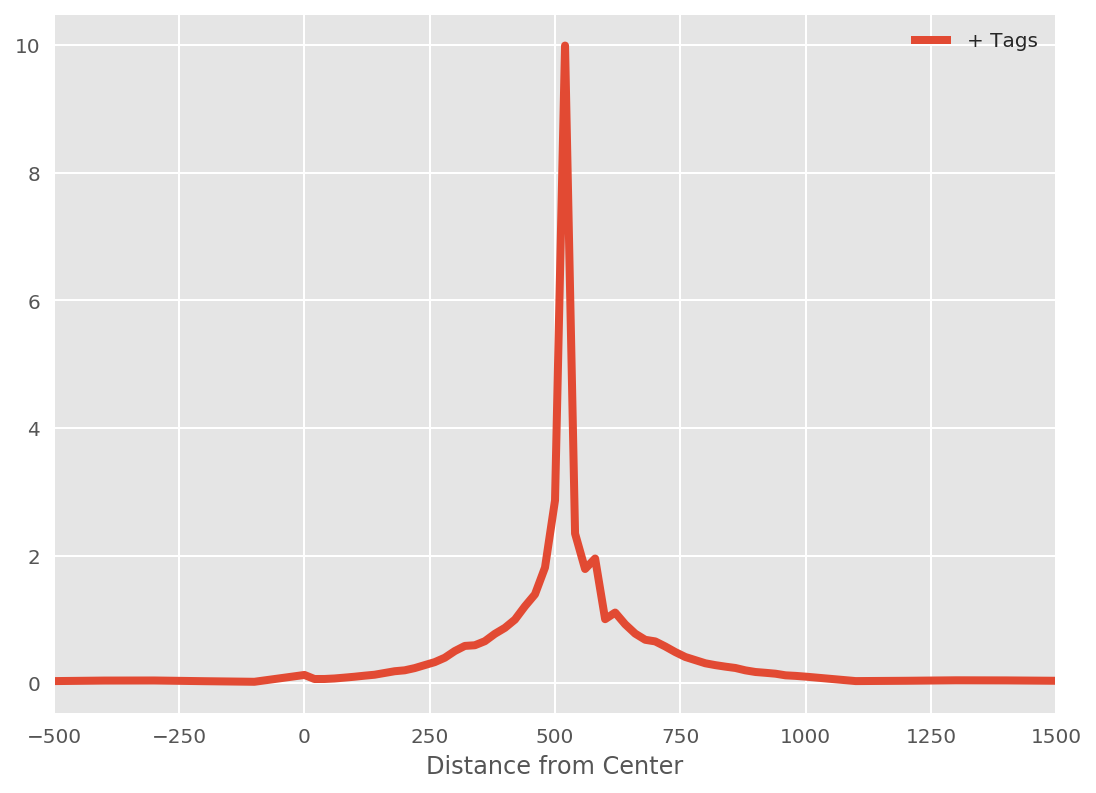

In [33]:

cho_metagene = pd.read_csv(out_file,sep='\t')
cols = cho_metagene.columns
cols = ['Distance from Center','Coverage','+ Tags','- Tags']
cho_metagene.columns = cols

f = plt.figure()
cho_metagene.plot('Distance from Center','Coverage')
f = plt.figure()
cho_metagene.plot('Distance from Center' ,'+ Tags')

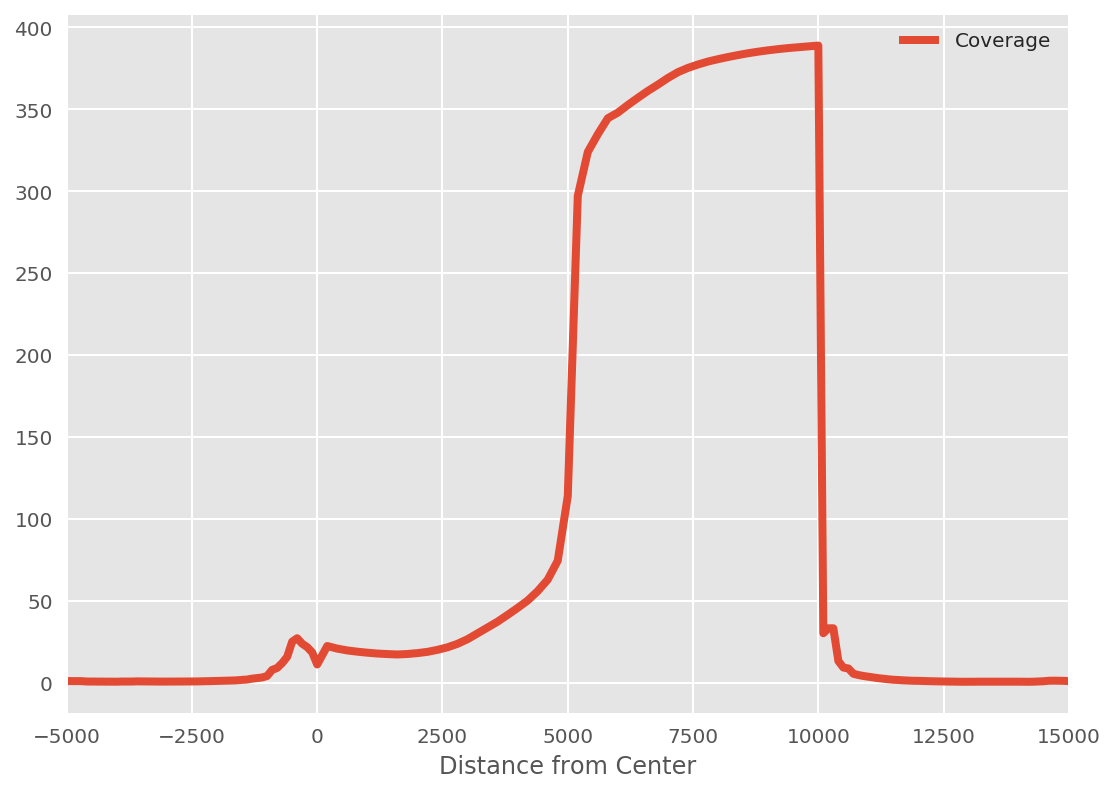

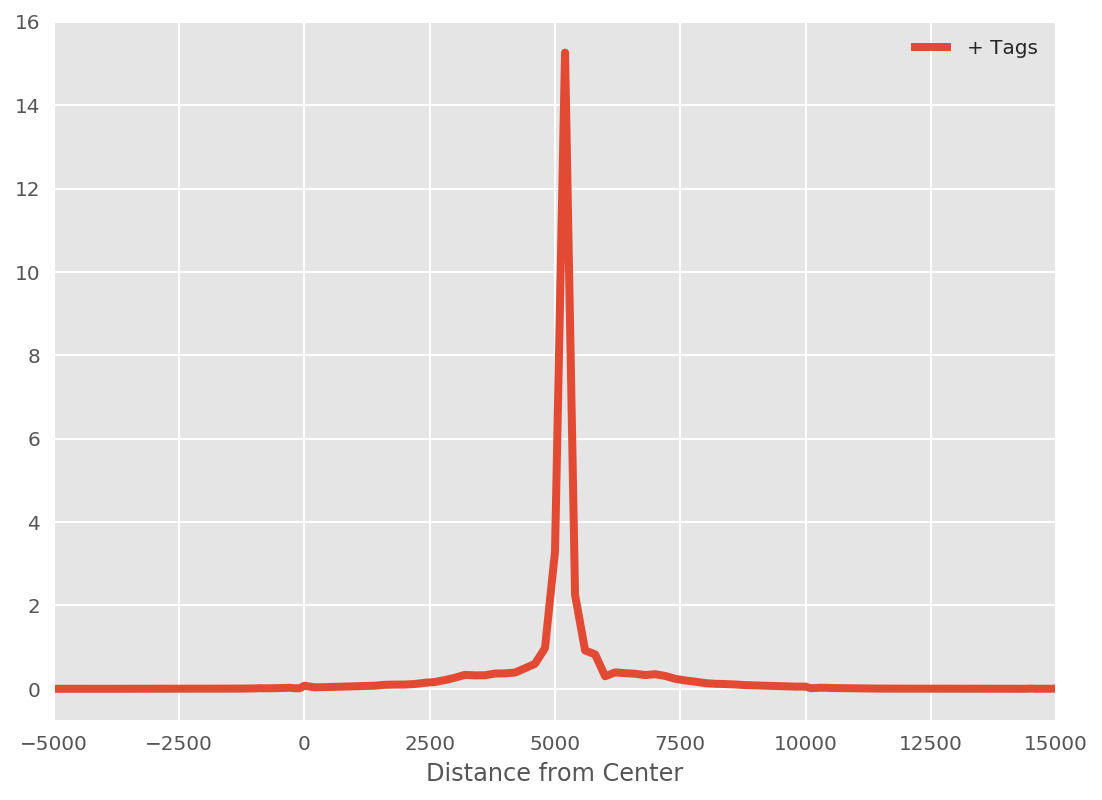

In [34]:
cho_metagene = pd.read_csv('CHO/mSTART/CHO_mSTART_metagene.txt',sep='\t')
cols = cho_metagene.columns
cols = ['Distance from Center','Coverage','+ Tags','- Tags']
cho_metagene.columns = cols

f = plt.figure()
cho_metagene.plot('Distance from Center','Coverage')
f = plt.figure()
cho_metagene.plot('Distance from Center' ,'+ Tags')